# Testing the API

In [1]:
from pathlib import Path
from functools import partial
#import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, compute_mesh_power, compute_mean_mesh_power,
compute_normalization, generate_anisotropic_gaussian_mesh, BinnedStatistic, utils)
from jaxwindow import WindowMatrixEstimator

plots_dir = Path('_plots')

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.linspace(1e-4, 0.4, 400)
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)
theory = BinnedStatistic(x=(kin,) * len(ells), value=poles, projs=ells)
edges = {'step': 0.005}

def make_callable(theory):
    def get_fun(proj): return lambda x: jnp.interp(x, theory.x(projs=proj), theory.view(projs=proj), left=0., right=0.)
    return {proj: get_fun(proj) for proj in theory.projs}

# Selection function
def gaussian_survey(boxsize=2000., meshsize=128, size=int(1e8), seed=random.key(42), scale=0.2, paint=False):
    # Generate Gaussian-distributed positions
    boxcenter = np.array((boxsize * 0.55, 0., 0.))
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * boxsize + boxcenter
    toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

# Apply selection function
def apply_selection(mesh, selection, cv=False):
    # Selection function
    mesh = mesh * selection
    if not cv:  # with radial integral constraint
        dmin = np.min(selection.boxcenter - selection.boxsize / 2.)
        dmax = (1. + 1e-9) * np.sqrt(np.sum((selection.boxcenter + selection.boxsize / 2.)**2))
        edges = jnp.linspace(dmin, dmax, 1000)
        rnorm = jnp.sqrt(sum(xx**2 for xx in selection.coords(sparse=True))).ravel()
        ibin = jnp.digitize(rnorm, edges, right=False)
        bw = jnp.bincount(ibin, weights=mesh.ravel(), length=len(edges) + 1)
        b = jnp.bincount(ibin, weights=selection.ravel(), length=len(edges) + 1)
        # Integral constraint
        bw = bw / jnp.where(b == 0., 1., b)  # (integral of W * delta) / (integral of W)
        mesh -= bw[ibin].reshape(selection.shape) * selection
    return mesh

# Mean control variate power spectrum
def mean_survey(poles, selection, los='local'):
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    poles = make_callable(poles)
    if los == 'local': poles = (poles, los)  # local line-of-sight
    return compute_mean_mesh_power(selection, theory=poles, edges=edges, ells=ells, los={'local': 'firstpoint'}.get(los, los)).clone(norm=norm)

# Difference: mock - control variate power spectrum
def mock_survey(theory, selection, with_cv=True, los='local', seed=42, unitary_amplitude=True):
    mesh = generate_anisotropic_gaussian_mesh(make_callable(theory), los=los, seed=seed,
                                              unitary_amplitude=unitary_amplitude, **selection.attrs)
    norm = compute_normalization(selection, selection)
    kw = dict(edges=edges, los={'local': 'firstpoint'}.get(los, los), ells=ells)
    power = compute_mesh_power(apply_selection(mesh, selection, cv=False), **kw).clone(norm=norm)
    if with_cv:
        cv = compute_mesh_power(apply_selection(mesh, selection, cv=True), **kw).clone(norm=norm)
        return power.clone(value=power.view() - cv.view())
    return power

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [3]:
gaussian_survey = jax.jit(gaussian_survey, static_argnames=['size', 'paint'])
selection = gaussian_survey(paint=True)

In [4]:
# First generate some mocks for the reference (not used in the window matrix calculation)
get_pk = lambda pkin, **kwargs: mock_survey(pkin, selection, with_cv=False, unitary_amplitude=False, **kwargs)
get_pk = jax.jit(get_pk)

from tqdm import trange
pks_ic = []
for imock in trange(1000):
    seed = random.key(2 * imock + 1)
    pks_ic.append(get_pk(theory, seed=seed))

100%|██████████| 1000/1000 [00:30<00:00, 33.24it/s]


In [5]:
estimator_cv = WindowMatrixEstimator(theory=theory)
# Compute control variate
estimator_cv.cv(mean_survey, func_kwargs=dict(selection=selection))
# Sample
nmocks = 25
estimator_cv.sample(partial(mock_survey, with_cv=True), nmocks=nmocks,
                    func_kwargs=dict(selection=selection))

wmat_cv = estimator_cv.mean()
std_cv = estimator_cv.std(std_on_mean=True)

100%|██████████| 3000/3000 [03:00<00:00, 16.63it/s]


In [6]:
estimator_brute = WindowMatrixEstimator(theory=theory)
estimator_brute.sample(partial(mock_survey, with_cv=False), nmocks=nmocks,
                       func_kwargs=dict(selection=selection))

wmat_brute = estimator_brute.mean()
std_brute = estimator_brute.std(std_on_mean=True)

100%|██████████| 3000/3000 [01:51<00:00, 26.82it/s]


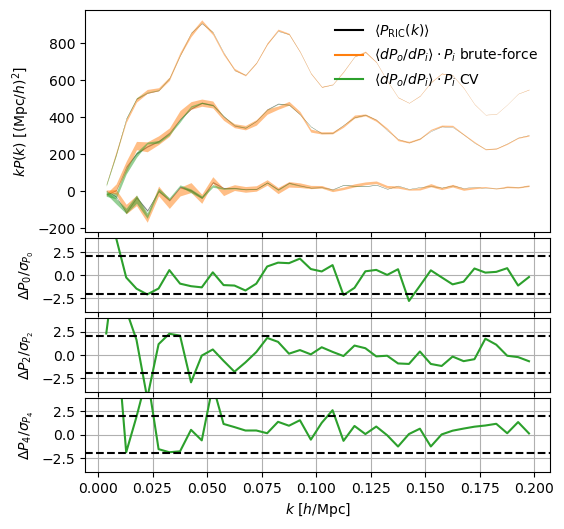

In [7]:
pkt_brute_mean, pkt_brute_std = np.array(wmat_brute.dot(poles.ravel(), zpt=False, return_type=None).value).real, np.array(std_brute.value).real
pkt_cv_mean, pkt_cv_std = np.array(wmat_cv.dot(poles.ravel(), zpt=False, return_type=None).value).real, np.array(std_cv.value).real
pk_ic_mean, pk_ic_std = np.mean([np.array(pk.value).real for pk in pks_ic], axis=0), np.std([np.array(pk.value).real for pk in pks_ic], axis=0) / np.sqrt(len(pks_ic))
k, edges = wmat_cv.observable.x(projs=0), wmat_cv.observable.edges(projs=0)

height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
maskin = kin < edges[-1]
colors = ['k', 'C1', 'C2']
labels = [r'$\langle P_\mathrm{RIC}(k) \rangle$',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ brute-force',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ CV']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    kw = dict(lw=0., alpha=0.5)
    ax.fill_between(k, k * (pk_ic_mean - pk_ic_std)[ill], k * (pk_ic_mean + pk_ic_std)[ill], color=colors[0], **kw)
    ax.fill_between(k, k * (pkt_brute_mean - pkt_brute_std)[ill], k * (pkt_brute_mean + pkt_brute_std)[ill], color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_cv_mean - pkt_cv_std)[ill], k * (pkt_cv_mean + pkt_cv_std)[ill], color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
factor = 1.
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    #ax.plot(k, (pk_ic_mean[ill] - pkt_brute_mean[ill]) / pk_ic_std[ill] * factor, color=colors[1])
    ax.plot(k, (pk_ic_mean[ill] - pkt_cv_mean[ill]) / pk_ic_std[ill] * factor, color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / 'mocks_ric_wmatrix.png')
plt.show()

It is nice to see that the control variate works well (green area smaller than orange). With just 25 mocks we are able to reach the precision of 1000 mock realizations for most observed $k$'s. We could probably increase the number of mocks just for observed low-$k$ bins. Let's try this!

In [8]:
# Add 50 mocks to the first 10 k-bins (all ells)
estimator_cv.sample(mock_survey, nmocks=2 * nmocks, func_kwargs=dict(selection=selection), indices=(Ellipsis, slice(10)))
wmat_cv_lowk = estimator_cv.mean()
std_cv_lowk = estimator_cv.std(std_on_mean=True)

100%|██████████| 1500/1500 [01:36<00:00, 15.58it/s]


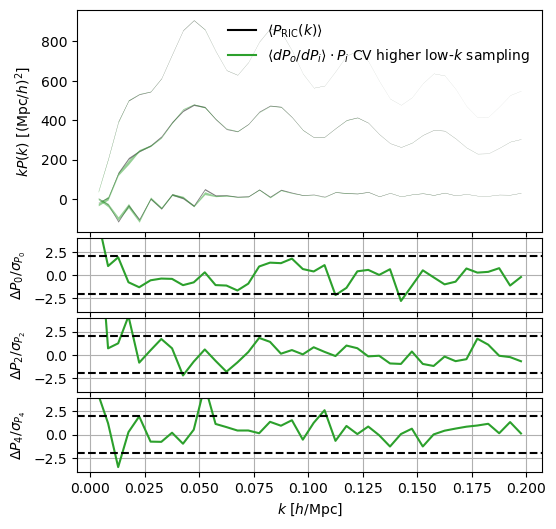

In [9]:
pkt_cv_lowk_mean, pkt_cv_lowk_std = np.array(wmat_cv_lowk.dot(poles.ravel(), zpt=False, return_type=None).value).real, np.array(std_cv_lowk.value).real

height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
maskin = kin < edges[-1]
colors = ['k', 'C2']
labels = [r'$\langle P_\mathrm{RIC}(k) \rangle$',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ CV higher low-$k$ sampling']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    kw = dict(lw=0., alpha=0.5)
    ax.fill_between(k, k * (pk_ic_mean - pk_ic_std)[ill], k * (pk_ic_mean + pk_ic_std)[ill], color=colors[0], **kw)
    ax.fill_between(k, k * (pkt_cv_lowk_mean - pkt_cv_lowk_std)[ill], k * (pkt_cv_lowk_mean + pkt_cv_lowk_std)[ill], color=colors[1], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
factor = 1.
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    ax.plot(k, (pk_ic_mean[ill] - pkt_cv_lowk_mean[ill]) / pk_ic_std[ill] * factor, color=colors[1])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / 'mocks_ric_wmatrix_lowk.png')
plt.show()

Low-k agreement is now much better!


To reduce the computational cost, we can try to evaluate the window matrix every $N$ $k$-bin.

In [10]:
estimator_cv_sparse = WindowMatrixEstimator(theory=theory)
# Compute control variate
estimator_cv_sparse.cv(mean_survey, func_kwargs=dict(selection=selection))
# Sample
nmocks = 25
estimator_cv_sparse.sample(partial(mock_survey, with_cv=True), nmocks=nmocks,
                           func_kwargs=dict(selection=selection),
                           indices=(Ellipsis, slice(0, None, 4)))
estimator_cv_sparse.sample(partial(mock_survey, with_cv=True), nmocks=2 * nmocks,
                           func_kwargs=dict(selection=selection),
                           indices=(Ellipsis, slice(10)))


100%|██████████| 1500/1500 [01:26<00:00, 17.37it/s]


In [11]:
estimator_cv_sparse.sample(partial(mock_survey, with_cv=True), nmocks=nmocks,
                           func_kwargs=dict(selection=selection),
                           indices=(Ellipsis, slice(-1, None)))
wmat_cv_sparse = estimator_cv_sparse.mean(interp=True)
std_cv_sparse = estimator_cv_sparse.std(interp=True, std_on_mean=True)

100%|██████████| 75/75 [00:10<00:00,  6.85it/s]


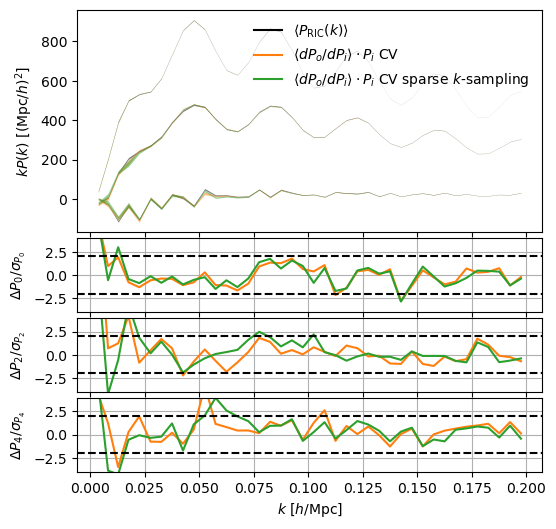

In [12]:
pkt_cv_sparse_mean, pkt_cv_sparse_std = np.array(wmat_cv_sparse.dot(poles.ravel(), zpt=False, return_type=None).value).real, np.array(std_cv_sparse.value).real

height_ratios = [max(len(ells), 3)] + [1] * len(ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0.05)
ax = lax[0]
maskin = kin < edges[-1]
colors = ['k', 'C1', 'C2']
labels = [r'$\langle P_\mathrm{RIC}(k) \rangle$',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ CV',
          r'$\langle dP_o/dP_i \rangle \cdot P_i$ CV sparse $k$-sampling']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    kw = dict(lw=0., alpha=0.5)
    ax.fill_between(k, k * (pk_ic_mean - pk_ic_std)[ill], k * (pk_ic_mean + pk_ic_std)[ill], color=colors[0], **kw)
    ax.fill_between(k, k * (pkt_cv_lowk_mean - pkt_cv_lowk_std)[ill], k * (pkt_cv_lowk_mean + pkt_cv_lowk_std)[ill], color=colors[1], **kw)
    ax.fill_between(k, k * (pkt_cv_sparse_mean - pkt_cv_sparse_std)[ill], k * (pkt_cv_sparse_mean + pkt_cv_sparse_std)[ill], color=colors[2], **kw)
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
factor = 1.
for ill, ell in enumerate(ells):
    ax = lax[ill + 1]
    ax.plot(k, (pk_ic_mean[ill] - pkt_cv_lowk_mean[ill]) / pk_ic_std[ill] * factor, color=colors[1])
    ax.plot(k, (pk_ic_mean[ill] - pkt_cv_sparse_mean[ill]) / pk_ic_std[ill] * factor, color=colors[2])
    ax.set_ylim(-3., 3.)
    ax.set_ylim(-4, 4)
    for offset in [-2., 2.]: ax.axhline(offset, color='k', linestyle='--')
    ax.grid(True)
    ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
utils.savefig(plots_dir / 'mocks_ric_wmatrix_sparse.png')
plt.show()

High-$k$ accuracy is not too impacted by sparse sampling.
In a nutshell, we only need $2000$ realizations to obtain the window matrix at the precision of $\mathcal{O}(10^3)$ mocks ($<5\%$ relative precision) for a realistic application case.
Note: this is the precision *on the deviation to the fiducial power spectrum*... i.e. we should be *very* safe.

Let's plot the window matrix.

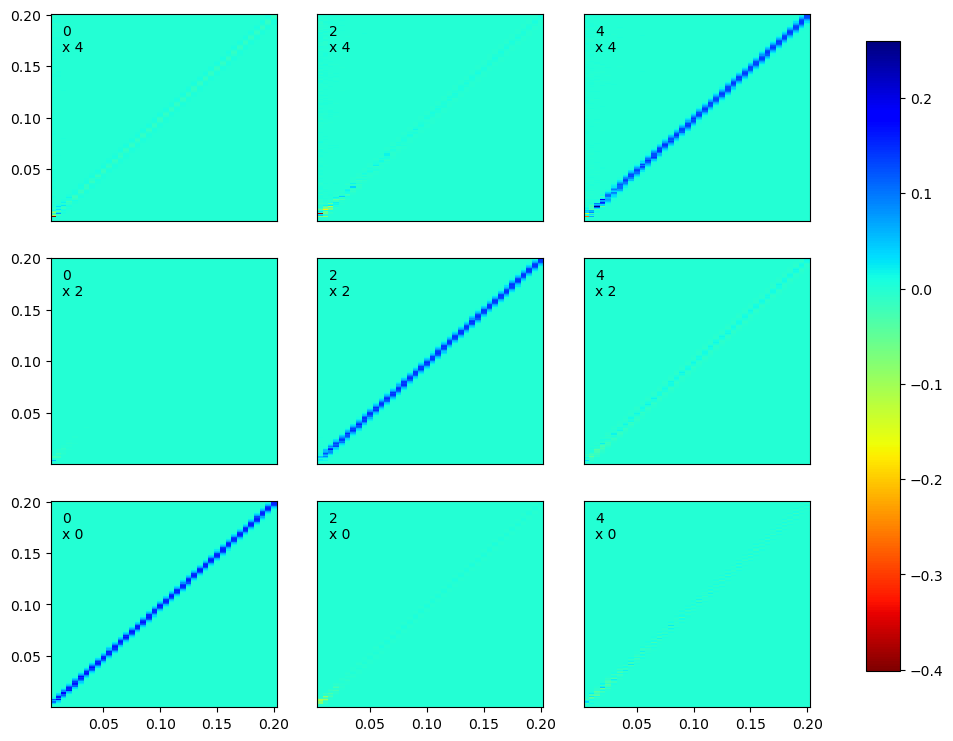

In [13]:
wmat_cv_lowk.select(xlim=(edges[0], edges[-1]), axis='t').plot(fn=plots_dir / 'wmatrix_ric.png');